In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
from scipy.ndimage import convolve, generate_binary_structure

In [2]:
# Modello di Ising tramite metropolis

def energia(Jconst, nx, ny, spins):
    spins1 = np.zeros((nx+2, ny+2))
    #periodic boundary conditions
    spins1[1:1+nx, 1:1+ny] = spins.copy()
    spins1[0, 1:nx+1] = spins[nx-1]
    spins1[nx+1, 1:nx+1] = spins[0]
    spins1[1:nx+1, 0] = spins[0:nx, nx-1]
    spins1[1:nx+1, nx+1] = spins[0:nx, 0]
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    ene = spins1 * convolve(spins1, kern, mode='constant', cval=0)
    ene = ene[1:1+nx, 1:1+ny]
    return -0.5*Jconst*ene.sum()

x0 = 1

def numero_random( ):
    a=16807
    c=0
    m=2147483647
    global x0
    x1=(a*x0+c)%m
    r=float(x1)/float(m)
    x0 = x1
    return r

def genera_configurazione(nx, ny, spins):
    for j in range(0, ny, 1):
        for i in range(0, nx, 1):
            r =numero_random()
            if (r<0.5):
                spins[j][i]=-1
            else:
                spins[j][i]=1
            
    return spins

def cambia_configurazione( Jconst, kbT, nx,  ny,  spins, energy, magn):
    
    en_i = 0
    en_f = 0
    
    x = math.floor(numero_random()*nx)
    y = math.floor(numero_random()*ny)
    spin_i = spins[x,y]
    spin_f = -spins[x, y]

    if x<nx-1:
        en_f+=-Jconst*spins[x+1, y]*spin_f
        en_i+=-Jconst*spins[x+1, y]*spin_i
    else:
        en_f+=-Jconst*spins[0 , y]*spin_f
        en_i+=-Jconst*spins[0, y]*spin_i
    
    if x > 0:
        en_f+=-Jconst*spins[x-1,y]*spin_f
        en_i+=-Jconst*spins[x-1, y]*spin_i
    else:
        en_f+=-Jconst*spins[nx-1,y]*spin_f
        en_i+=-Jconst*spins[nx-1, y]*spin_i
        

    if y < ny-1:
        en_f+=-Jconst*spins[x, y+1]*spin_f
        en_i+=-Jconst*spins[x, y+1]*spin_i
    else:
        en_f+=-Jconst*spins[x, 0]*spin_f
        en_i+=-Jconst*spins[x, 0]*spin_i
    if y > 0 :
        en_f+=-Jconst*spins[x, y-1]*spin_f
        en_i+=-Jconst*spins[x, y-1]*spin_i
    else:
        en_f+=-Jconst*spins[x, ny-1]*spin_f
        en_i+=-Jconst*spins[x, ny-1]*spin_i
        
        
    de = en_f - en_i
    
    if de <= 0:
        spins[x,y] = spin_f
    elif (de > 0)*(numero_random() < np.exp(-de/kbT)):
        spins[x,y] = spin_f
    else: 
        de = 0
        spin_f = spin_i
    return energy+de, magn + (spin_f - spin_i),  spins
    

def magnetizzazione(spins):
    return spins.sum()

def metropolis(spins, steps, nx, ny, J, kbT, energy, magn):
    d_spins = np.zeros(steps)
    d_energy = np.zeros(steps)
    for s in range(0, steps):
        d_energy[s], d_spins[s], spins = cambia_configurazione(J, kbT, nx, ny, spins, energy, magn)
        energy = d_energy[s]
        magn = d_spins[s]
        
        if s % (steps/100) == 0: 
            print(str(100*s/steps)+"% Processing", end ="\r")
            #print(str(100*s/steps)+"% Processing" + "  energia %f vs energia_0 %f" % (energy/(nx*ny), energia(J, nx, ny, spins)/(nx*ny)) , end ="\r")

    print("Done            ", end ="\r")
    return d_energy, d_spins, spins 

In [3]:
nsteps = 10**8

def main(kbT):
    nx,ny = 50, 50 # 20, 20 # 50, 50
    J = 1 # kbT in [0, 3]
    spins = np.zeros((nx,ny), dtype = float)
    spins = genera_configurazione(nx, ny, spins)
    spins0 = spins.copy()
    magn_0 = magnetizzazione(spins0)
    en_0 = energia(J, nx, ny, spins0)
    dE, dSpins, spins = metropolis(spins, nsteps, nx, ny, J, kbT, en_0, magn_0)
    return dE, dSpins, nx, ny, spins0, spins

def plot(kbT):
    de, dspi, nx, ny, spins0, spins = main(kbT)

    fig, axs = plt.subplots(2,2, figsize=(10,10))

    axs[1][0].set_title("Configurazione iniziale")
    axs[1][0].imshow(spins0)
    axs[1][1].set_title("Configurazione finale")
    axs[1][1].imshow(spins)

    t = np.linspace(0,nsteps, nsteps)

    axs[0][0].clear()
    axs[0][0].plot(de/(nx*ny))
    axs[0][0].set_title("Energia per sito")
    axs[0][0].set_xlabel(r'steps')

    axs[0][1].clear()
    axs[0][1].plot(dspi/(nx*ny))
    axs[0][1].set_title("Magnetizzazione per sito")
    axs[0][1].set_xlabel(r'steps')

    tit = "kbT: " + str(kbT)+ ", nx: "+ str(nx)+ ", ny: "+ str(ny) + ", J: 1" 
    fig.suptitle(tit)
    fig.savefig("kbT"+str(kbT)+".png")
    return

<IPython.core.display.Javascript object>


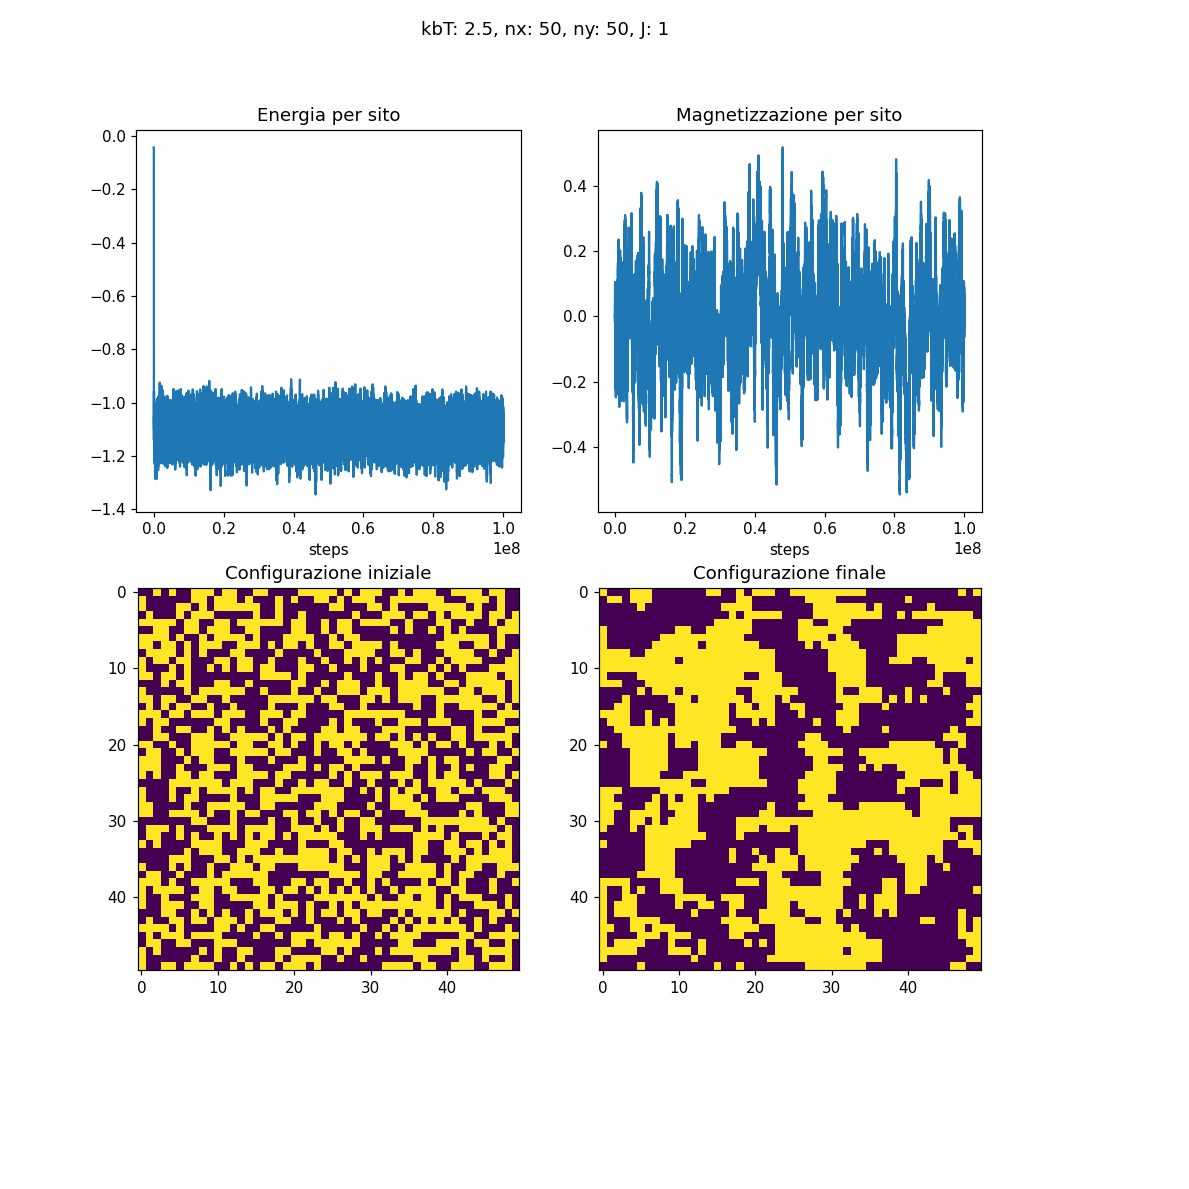

In [4]:
plot(2.5)